# Speaker diarization with Gen (v3 w/ super-pixels)

We follow to a great part the example in the Gen ["Reversible-Jump MCMC" tutorial](https://www.gen.dev/tutorials/rj/tutorial) on the Gen [website](https://www.gen.dev). The piecewise constant function play the role of the speaker tracks in the diarization task.

In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
import PyPlot
plt = PyPlot.plt
plt.style.use("default")
using NPZ

In [3]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal, norm, diagm, diagind
using JSON
using JLD

In [4]:
using Base.Iterators: flatten

## Useful Distributions

### Dirichlet Dist

In [5]:
"""
    Dirichlet distribution: `dirichlet(N,a) = Dir(a, ... , a)`
"""
struct Dir <: Gen.Distribution{Vector{Float64}} end
const dirichlet = Dir()
function Gen.logpdf(::Dir, x::AbstractArray{Float64,1}, N::Int, a::Float64)
    dist = Dirichlet(N, a)
    return Distributions.logpdf(dist, x)
end
function Gen.random(::Dir, N::Int, a::Float64)
    dist = Dirichlet(N, a)
    x = rand(dist)
    return x[:,1]
end
(::Dir)(N,a) = Gen.random(Dir(), N, a)
Gen.has_output_grad(::Dir) = false;
Gen.has_argument_grads(::Dir) = (false,);

### Fractions Dist

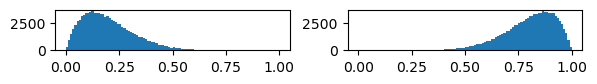

In [6]:
#
# The mean of `beta(a,b)` is given by `a/(a+b)`
# 
# For a given `mu` we can compute b, or a, as a function 
# of a, or b, respectively.
#
mu1 =       0.2
mu2 = 1.0 - mu1
C = 2.0
 
a1 = C
b1 = -(mu1*a1 - a1)/mu1

b2 = C
a2 = - mu2/(mu2-1)*b2

# ----------------
fig, axs = plt.subplots(1,2, figsize=(6,1)); fig.tight_layout();
axs[1].hist([beta(a1,b1) for t=1:100000], bins=0:0.01:1);
axs[2].hist([beta(a2,b2) for t=1:100000], bins=0:0.01:1);

In [7]:
"""
    refraction(i, fractions, c)

Distribution to let us resample an inner point of a
partition `fr = [p1,...,pN]` of the unit interval.

Example:

If N=4, we can call it with i=1,2,3, which 
moves the respective point between the preceding 
point and the one after....


           p1    p2   p3      p4
        [------|----|----|----------]
        0     i=1  i=2  i=3         1

"""
struct FractionDist <: Gen.Distribution{Vector{Float64}} end
const refraction = FractionDist()
function Gen.logpdf(::FractionDist, x::AbstractArray{Float64,1}, i::Int64, fr::AbstractArray{Float64,1}, c::Float64)
    @assert(0<i && i<length(fr))
    mu = fr[i]/(fr[i] + fr[i+1])
    
    if mu < 0.5
        a = c
        b = -(mu*a - a)/mu
    elseif mu > 0.5
        b = c
        a = - mu/(mu-1)*b
    else
        a = c
        b = c
    end
    
    return Gen.logpdf(beta, mu, a, b)
end
function Gen.random(::FractionDist,  i::Int64, fr::AbstractArray{Float64,1}, c::Float64)
    @assert(0<i && i<length(fr))
    X  = fr[i] + fr[i+1] 
    mu = fr[i]/X
    
    if mu < 0.5
        a = c
        b = -(mu*a - a)/mu
    elseif mu > 0.5
        b = c
        a = - mu/(mu-1)*b
    else
        a = c
        b = c
    end
    
    s = beta(a,b)

    return [fr[1:i-1];s*X;(1-s)*X;fr[i+2:end]]
end
(::FractionDist)(i, fr, c) = Gen.random(FractionDist(), i, fr, c)
Gen.has_output_grad(::FractionDist) = false;
Gen.has_argument_grads(::FractionDist) = (false,false,false);

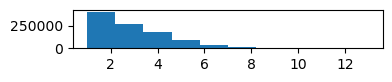

In [8]:
"""
    poisson_plus_one(λ)

A shifted poisson distribution that is guaranteed to be 1 or higher.
"""
@dist poisson_plus_one(rate) = poisson(rate) + 1;
# ------------------------
plt.figure(figsize=(4,0.5))
plt.hist([poisson_plus_one(2) for t in 1:1000_000]);

In [9]:
x = rand(1_000,1_000) 
@btime collect(Iterators.flatten(x)); #  1.411 ms (3 allocations: 7.63 MiB)
@btime vcat(x...);                    # 20.374 ms (1000003 allocations: 30.52 MiB)

  1.303 ms (3 allocations: 7.63 MiB)
  18.796 ms (1000003 allocations: 30.52 MiB)


In [15]:
@dist function mv2dnormal(Mu, Var)
    mu  = collect(Iterators.flatten(Mu))
    var = collect(Iterators.flatten(Var))
    x = mvnormal(mu, diagm(var))
    x
end

Gen.CompiledDistWithArgs{Array{Float64,1}}(Gen.MultivariateNormal(), 2, Bool[1, 1], (Gen.TransformedArg{Any}(Gen.Arg[Gen.TransformedArg{Any}(Gen.Arg[Gen.SimpleArg{Any}(1)], Base.Iterators.flatten, var"#79#80"())], collect, var"#81#82"()), Gen.TransformedArg{Any}(Gen.Arg[Gen.TransformedArg{Any}(Gen.Arg[Gen.TransformedArg{Any}(Gen.Arg[Gen.SimpleArg{Any}(2)], Base.Iterators.flatten, var"#83#84"())], collect, var"#85#86"())], LinearAlgebra.diagm, var"#87#88"())))

## The generative model

Given: 

- $M$ - maximal number of speakers
- $T$ - Number of columns/row in the speaker similarity matrix we're sampling

Model:
- $N \sim P(\#\text{Segments})$
- $\text{fr} \sim \text{Dir}(N, 2.0)$
- For  $n=1,...,N$ sample a speaker id: 
    - $\text{id}_n \sim \text{Cat}(1,M)$
- For $i=1,...,T$, $j=1,...,T$ sample a distance:
    - $d_{i,j} \sim ... $
- ...


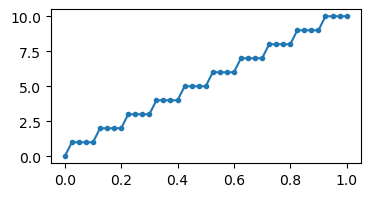

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe4cbfb6070>

In [9]:
function to_index(x; T)
    return Int(ceil(x/(1/T)))
end

T  = 10
xs = collect(0:0.025:1)

# ----------------------
plt.figure(figsize=(4,2))
plt.plot(xs,to_index.(xs, T=10),marker=".")

In [10]:
function argchanges(B)
    return Tuple(b==1 ? UnknownChange() : NoChange() for b in B)
end

argchanges (generic function with 1 method)

In [20]:
"""
    matrix_model(M, T)

Speaker similarity matrix model.
"""
@gen function matrix_model_w_sub(max_speaker::Int, T::Int, t_sub=nothing)
    
    xs   = collect(0:1/(T-1):1)
    xmin = minimum(xs)
    xmax = maximum(xs)
    M  = max_speaker    
    
    N  = @trace(poisson_plus_one(4), :num_segments)
    fr = {:fractions} ~ dirichlet(N, 2.0)
    cumfracs = cumsum(fr)
    cumfracs[end] = 1.0 # Correct numeric issue: `cumfracs[end]` might be 0.999999

    ids = [{(:id, i)} ~ categorical(ones(M)./M) for i=1:N] 
    I   = [findfirst(frac -> frac >= (x - xmin) / (xmax - xmin), cumfracs) for x in xs]
    ys  = ids[I]
    
        
    D = zeros(T,T)
    if t_sub == nothing
        t_sub = 1:T
    end
    for i in 1:T, j in t_sub
            if i==j
                D[i,i] = {:D => (i, i)} ~ normal(1, 0.1)
            else
                if ys[i]==ys[j]
                    D[i,j] = {:D => (i, j)} ~ normal(0.5, 0.2)
                else
                    D[i,j] = {:D => (i, j)} ~ normal(0.15, 0.2)
                end
            end
    end

    
    
    
    segs = hcat([0; cumfracs[1:end-1]], cumfracs)
    speaker_to_segs = Dict()
    
    for i=1:N
        if !haskey(speaker_to_segs, ids[i]); speaker_to_segs[ids[i]] = []; end;
        push!(speaker_to_segs[ids[i]], segs[i,:])
    end
    
    return Dict(
        :xs => 1 .+ (T-1) .* xs,
        :ys => ys, 
        :D  => D, 
        :cumfracs => cumfracs,
        :speaker_to_segs => speaker_to_segs)
end

matrix_model_w_sub

In [21]:
function make_obs(D)
    H,W = size(D)
    ch = choicemap()
    for i=1:H, j=i:W
        ch[:D => (i, j)] = D[i,j]
        ch[:D => (j, i)] = D[j,i]
    end
    return ch
end

make_obs (generic function with 1 method)

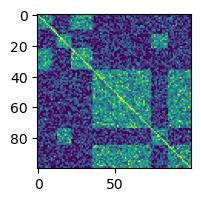

1830.565686527453

PyObject <matplotlib.image.AxesImage object at 0x7fdd8984c3d0>

In [213]:
tr, w = generate(matrix_model, (5, 100, nothing), choicemap());
D = get_retval(tr)[:D]
print(get_score(tr))
obs = make_obs(D);
# -------
plt.figure(figsize=(2,2))
plt.imshow(D, vmin=0, vmax=1)

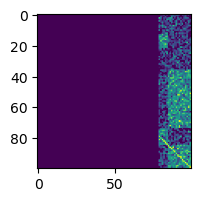

370.14468011793224

PyObject <matplotlib.image.AxesImage object at 0x7fdd89855160>

In [214]:
argdiffs = argchanges([0,0,1])
tr_, w, retdiff, discard = update(tr, (10, 100, 80:100), argdiffs, choicemap());

D = get_retval(tr_)[:D]
print(get_score(tr_))
# -------
plt.figure(figsize=(2,2))
plt.imshow(D, vmin=0, vmax=1)

In [215]:
@btime generate(matrix_model, (5, 100, nothing), obs);

  8.176 ms (145853 allocations: 4.73 MiB)


In [217]:
@btime update(tr, (5, 100, 80:100), argdiffs, choicemap());

  7.890 ms (191644 allocations: 5.69 MiB)


In [218]:
@btime regenerate(tr, (5, 100, 80:100), argdiffs, EmptySelection());

  3.303 ms (50224 allocations: 1.63 MiB)


In [219]:
@btime regenerate(tr, (5, 100, nothing), argdiffs, EmptySelection());

  11.813 ms (200433 allocations: 6.10 MiB)


In [38]:
@gen (static) function static_speaker_id_model(M::Int)
    id ~ categorical(ones(M)./M)
    return id
end

@load_generated_functions 

In [43]:
@gen function test(x)
    y ~ normal(0, 1)
end
@gen function Dij_model(ij, ys)
    i,j = Tuple(ij)
    if i==j
        d ~ normal(1, 0.1)
    else
        if ys[i]==ys[j]
            d ~ normal(0.5, 0.2)
        else
            d ~ normal(0.15, 0.2)
        end
    end
    d
end


DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], ##Dij_model#689, Bool[0, 0], false)

In [48]:
"""
    matrix_model(M, T)

Speaker similarity matrix model.
"""
@gen (static) function static_matrix_model(max_speaker::Int, T::Int)

    xs = collect(0:1/(T-1):1)
    M = max_speaker
    xmin = minimum(xs)
    xmax = maximum(xs)
    
    N  = {:num_segments} ~ poisson_plus_one(4)
    fr = {:fractions}    ~ dirichlet(N, 2.0)
    cumfracs = [cumsum(fr)[1:end-1]; 1.0]

    # Correct numeric issue: `cumfracs[end]` might be 0.999999
    # usually we'd set cumfracs[end] = 1.0, but it doesn't seem 
    # to be allowed in a static fct


    speaker_ids ~ Map(static_speaker_id_model)(fill(M, N))    
    
    inds = [findfirst(frac -> frac >= (x - xmin) / (xmax - xmin), cumfracs) for x in xs]
    ys   = speaker_ids[inds]
    
    
    
    D ~ Map(Dij_model)(CartesianIndices((T,T)), fill(ys, (T,T)))      
    
    
    return D
end

@load_generated_functions 


In [59]:
@btime generate(static_matrix_model, (10,20), choicemap());

  832.985 μs (16577 allocations: 1.14 MiB)


In [51]:
addr = ( :speaker_ids => 1 => :id)
addr = ( :D => 1 => :d)
tr[addr]

0.8714201508504156

### Trace helper

In [54]:
"""
    make_obs(D) -> choicemap

Conveniently create a observation choicemap 
from a similarity matrix.
"""
function make_obs(D)
    H,W = size(D)
    ch = choicemap()
    for (i,I) in enumerate(CartesianIndices((H,W)))
        ch[:D => i => :d] = D[Tuple(I)...]
    end
    return ch
end

make_obs

### Visualizations and visual tests

In [55]:
function make_speaker_map(ys)
    T = length(ys)
    SM = zeros(T,T)
    P = zeros(T,T)
    for i in 1:T
        for j in 1:T
            a = float(ys[i] == ys[j])
            SM[i,j] = a*ys[i]
            P[i,j] = project()
        end
    end
    return SM
end

make_speaker_map (generic function with 1 method)

In [56]:
function make_prob_map(tr)
    M,T, = get_args(tr)
    P = zeros(T,T)
    for i in 1:T
        for j in i:T
            p_ij = project(tr, select(:D => (:d, i, j)))
            P[i,j] = exp(p_ij)
            P[j,i] = exp(p_ij)
        end
    end
    return P
end

make_prob_map (generic function with 1 method)

In [ ]:
function plot_tr(tr, figsize=(10,2))
    M, = get_args(tr)
    ret = get_retval(tr)
    sp_map = make_speaker_map(ret[:ys])
    P = make_prob_map(tr)
    ############
    fig, axs = plt.subplots(1,4,figsize=figsize)
    fig.tight_layout()
    axs[1].imshow(ret[:D]); 
    axs[2].imshow(P, vmin=0, vmax=1, cmap="winter")
    
    axs[3].imshow(sp_map);
    for (i, segs) in ret[:speaker_to_segs]
        axs[4].hlines(i,0,1, color="silver", linewidth=0.5, alpha=0.5, linestyle="-", zorder=0)
        for s in segs; axs[4].plot(s,[i,i], marker="|", c="C0", zorder=1); end
    end
end

plot_tr (generic function with 2 methods)

In [ ]:
T = 100
M =  10
args = (M, T);

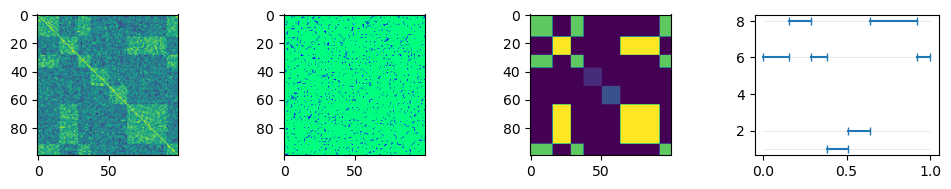

In [ ]:
tr = simulate(matrix_model, args)
# ------------
plot_tr(tr);

In [ ]:
ch = get_submap(get_choices(tr), :D)
ch;

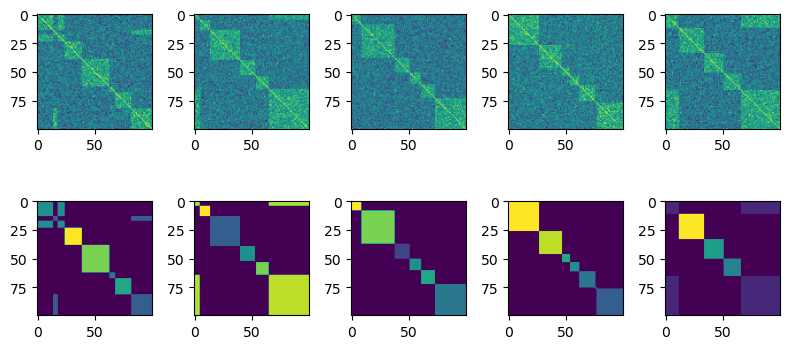

In [ ]:
# -------
fig, axs = plt.subplots(2, 5, figsize=(8,4))
for i in 1:5
    ret = matrix_model(args...)
    axs[1,i].imshow(ret[:D])
    axs[2,i].imshow(make_speaker_map(ret[:ys]))
end
fig.tight_layout()

### Observations

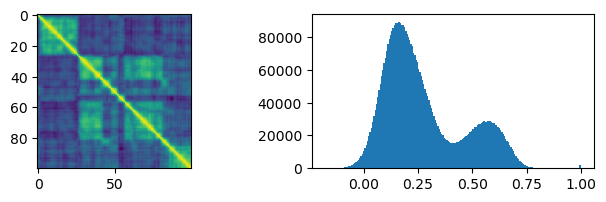

In [ ]:
xtask = 10
data_path = "_nbx_distances/results/$(xtask-1)/D.npy"
D_ = npzread(data_path)
D = D_[1:T,1:T] 
# --------
fig, axs = plt.subplots(1,2,figsize=(8,2))
axs[1].imshow(D); axs[2].hist(vcat(D_...), bins=200);

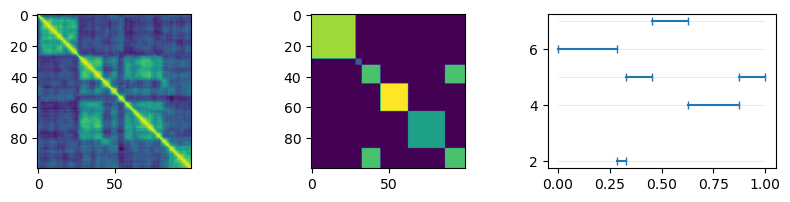

In [ ]:
obs = make_obs(D)
tr, w = generate(matrix_model, args, obs)
# --------------
plot_tr(tr);

### Naive inference - 2 quick reality check

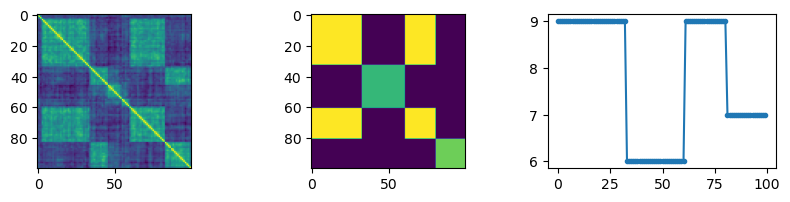

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8758aa66d0>

In [ ]:
trs, ws, _ = importance_sampling(matrix_model, args, obs, 1_000, false);
tr = trs[argmax(ws)]
# -----------
plot_tr(tr)

 500 1000 1500 2000 2500 3000 3500 4000 4500

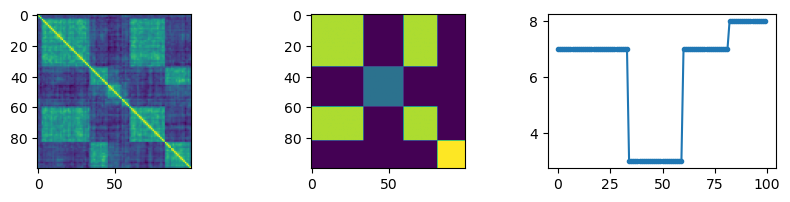

 5000

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8758abb100>

In [ ]:
w_max  = -Inf
tr_max = nothing
for t = 1:5_000
    if t%500 == 0; print(" ", t); end
    
    tr, w = generate(matrix_model, args, obs);

    if w > w_max
        w_max  = w
        tr_max = tr
    end
end
# -----------
plot_tr(tr_max)

## Reversible Jump MCMC

### Proposal

In [ ]:
@gen function proposal(tr)
    
    M, = get_args(tr)
    N  = tr[:num_segments]
    fr = tr[:fractions]
    
    if ({:split} ~ bernoulli(N == 1 ? 1 : 0.3))
        
        {:i} ~ uniform_discrete(1, N)
        {:split_fraction} ~ uniform(0, 1)
        {:change_left} ~ bernoulli(0.5)
        {:new_id} ~ uniform_discrete(1, M)
        
    else
        
        {:i} ~ uniform_discrete(1, N-1)
        {:change_left} ~ bernoulli(0.5)
        
    end
end;
    

### Involution
```
    prop(t, args) --> ch, ret

    i(t , ch , ret    , args) --> t', ch', w'
    
    i(t', ch', ret(?) , args) --> t , ch , w
```

In [ ]:
function involution(tr, ch, ret, _)
    
    M, = get_args(tr)
    N  = tr[:num_segments]
    fr = tr[:fractions]

    ch_ = choicemap()
    if ch[:split]
        
        i = ch[:i]
        s = ch[:split_fraction]

        
        upd = choicemap()
        upd[:num_segments] = N + 1
        
        upd[:fractions] = [fr[1:i-1]; s*fr[i]; (1-s)*fr[i]; fr[i+1:end]]
        
        
        for j = N:-1:i+1
            # updates from i+2 onward....
            upd[(:id, j+1)] = tr[(:id, j)]
        end
            
        # updates from i, and i+1
        if ch[:change_left]
            upd[(:id, i)]   = ch[:new_id]
            upd[(:id, i+1)] = tr[(:id, i)]
        else
            upd[(:id, i)]   = tr[(:id, i)]
            upd[(:id, i+1)] = ch[:new_id]
        end
        

        
    else    
        i = ch[:i]
        
        upd = choicemap()
        upd[:num_segments] = N - 1
        
        upd[:fractions] = [fr[1:i-1]; fr[i] + fr[i+1]; fr[i+2:end]]
        
        
        if ch[:change_left]    
            upd[(:id, i)] = tr[(:id, i + 1)]  
        end
        
        for j = i+1:N-1
            upd[(:id, j)] = tr[(:id, j+1)]
        end
        
        
        

        
    end
    
    #
    # Backwards updates
    #
    
    ch_[:split] = !ch[:split]
    
    if ch[:split]
        ch_[:change_left] = ch[:change_left]
        ch_[:i] = i
    else
        if ch[:change_left]    
            ch_[:new_id] = tr[(:id, i)]     
        else
            ch_[:new_id] = tr[(:id, i + 1)] 
        end
        
        
        ch_[:split_fraction] = fr[i]/(fr[i] + fr[i+1])
        ch_[:i] = i
        ch_[:change_left] = ch[:change_left]
    end
    
    
    new_trace, weight, = update(tr, get_args(tr), (NoChange(),), upd)
    (new_trace, ch_, weight)
end

involution (generic function with 1 method)

### Involution test

In [ ]:
obs = make_obs(D)
tr, w = generate(step_func, args, obs)
plot_tr(tr)

In [ ]:
tr[:num_segments]

In [ ]:
prop_tr = simulate(proposal, (tr,))
get_choices(prop_tr)

In [ ]:
tr_, bch, w = involution(tr, get_choices(prop_tr), (), ())
plot_tr(tr_)

In [ ]:
tr_, bbch, w = involution(tr_, bch, (), ())
plot_tr(tr_)

In [ ]:
tr_, a = mh(tr, proposal, (), involution)
print(a)
plot_tr(tr)
plot_tr(tr_)

In [ ]:
tr_ = tr
for c1=1:100
    tr_[:num_segments]
    tr_, a = mh(tr_, proposal, (), involution)
    print("$c1 ($a) (N=$N)", " - ")
    for c2=1:5
        for i=1:N
            tr_, = mh(tr_, select((:id, i)))
        end
    end
end

In [ ]:
plot_tr(tr)
plot_tr(tr_)

### Fractions MH step

In [ ]:
function fraction_update(tr, i)
    if i == tr[:num_segments]
        return tr, 1
    end
    fr = tr[:fractions]
    new = copy(fr) 
    s = beta(2,2)
    new[i]   =     s*(fr[i] + fr[i+1])
    new[i+1] = (1-s)*(fr[i] + fr[i+1])
    upd = choicemap(:fractions => new)
    

    args = get_args(tr)
    argdiffs = map((_) -> NoChange(), args)

    (new_trace, weight) = update(tr,  args, argdiffs, upd)
    return (new_trace, weight)
end

In [ ]:
function mh_fraction_proposal(tr, i)
    (new_trace, weight) = fraction_update(tr, i)
    
    if log(rand()) < weight
        # accept
        return (new_trace, true)
    else
        # reject
        return (tr, false)
    end
     
end

### Fractions proposal

In [ ]:
@gen function fractions_proposal(tr, i)
    fr = tr[:fractions]
    {:fractions} ~ refraction(i, fr, 9.)
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], ##fractions_proposal#442, Bool[0, 0], false)

In [ ]:
tr,w = generate(step_func, args, obs);
plot_tr(tr)
tr[:fractions][1]

In [ ]:
N = tr[:num_segments]
i = 1; @assert i < N;
tr_, a = mh(tr, fractions_proposal, (i,));
plot_tr(tr_)
a, tr_[:fractions][1]

## Inference

In [ ]:
xtask = 10
data_path = "_nbx_distances/results/$(xtask-1)/D.npy"
D_ = npzread(data_path)
D = D_[1:T,1:T] 
obs = make_obs(D);

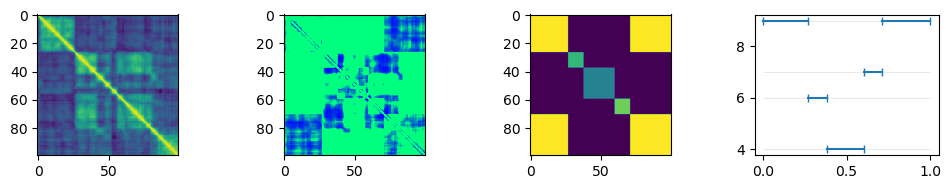

In [ ]:
tr,w = generate(matrix_model, args, obs);
# --------
plot_tr(tr)

### Inference with custom `refractions` dist 

In [ ]:
tr_ = tr
for c1=1:500
    
    tr_, a = mh(tr_, proposal, (), involution)
    N = tr_[:num_segments]
    if c1 % 10 == 0
        print("$c1 ($a) (N=$N)", " - ")
    end

    for i=1:N
        for c2=1:5
            if i < N
                tr_, a = mh(tr_, fractions_proposal, (i,));
            end
        end
        for c2=1:5
            tr_, = mh(tr_, select((:id, i)))
        end
    end
end

10 (false) (N=6) - 20 (false) (N=6) - 30 (false) (N=6) - 40 (true) (N=7) - 50 (false) (N=6) - 60 (true) (N=7) - 70 (false) (N=7) - 80 (true) (N=8) - 90 (false) (N=9) - 100 (true) (N=10) - 110 (false) (N=9) - 120 (false) (N=9) - 130 (true) (N=8) - 140 (false) (N=8) - 150 (false) (N=8) - 160 (false) (N=8) - 170 (false) (N=8) - 180 (false) (N=8) - 190 (false) (N=8) - 200 (true) (N=9) - 210 (false) (N=8) - 220 (false) (N=8) - 230 (false) (N=8) - 240 (false) (N=8) - 250 (false) (N=8) - 260 (false) (N=8) - 270 (false) (N=8) - 280 (false) (N=8) - 290 (false) (N=8) - 300 (false) (N=8) - 310 (false) (N=9) - 320 (true) (N=10) - 330 (false) (N=8) - 340 (false) (N=8) - 350 (false) (N=7) - 360 (false) (N=7) - 370 (false) (N=7) - 380 (true) (N=8) - 390 (false) (N=7) - 400 (false) (N=9) - 410 (false) (N=7) - 420 (false) (N=7) - 430 (true) (N=10) - 440 (false) (N=11) - 450 (false) (N=12) - 460 (false) (N=11) - 470 (false) (N=11) - 480 (true) (N=9) - 490 (false) (N=10) - 500 (false) (N=9) - 

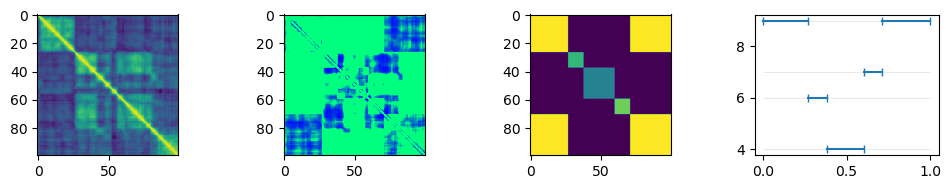

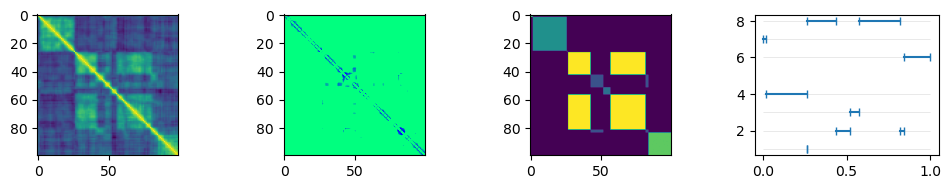

In [ ]:
plot_tr(tr)
plot_tr(tr_)

### Inference with Fractions MH Step

In [ ]:
tr_ = tr
for c1=1:100
    
    tr_, a = mh(tr_, proposal, (), involution)
    if c1 % 10 == 0
        print("$c1 ($a) (N=$N)", " - ")
    end
    N = tr_[:num_segments]
    for i=1:N
        for c2=1:5
            tr_, = mh_fraction_proposal(tr_, i)
        end
        for c2=1:5
            tr_, = mh(tr_, select((:id, i)))
        end
    end
end

In [ ]:
plot_tr(tr)
plot_tr(tr_)